In [1]:
import requests
import json
import numpy as np
import tensorflow as tf

2022-02-06 16:25:31.364527: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-06 16:25:31.364608: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2347]:
host = 'http://127.0.0.1:8000'

In [2348]:
url = f"{host}/evasion/api/get_challenge"
response = requests.get(url)

In [2349]:
response = json.loads(response.text)

In [2350]:
headers = {'Content-Type': 'application/octet-stream'}

In [2351]:
response

{'id': 7,
 'start_time': '2022-02-06T22:33:13.393Z',
 'end_time': '2022-02-06T22:38:13.393Z',
 'token': '',
 'indices': [13259,
  28132,
  24559,
  11368,
  38221,
  19010,
  41288,
  25894,
  33691,
  34020,
  28204,
  18509,
  19005,
  38,
  35139,
  19317,
  42396,
  9384,
  39404,
  5595,
  31034,
  38469,
  23449,
  16011,
  8219,
  15229,
  39616,
  16657,
  29140,
  43327,
  47941,
  10956,
  19971,
  18294,
  26589,
  36424,
  25201,
  37995,
  3301,
  10535,
  17916,
  47618,
  23881,
  11991,
  1541,
  1273,
  24438,
  10041,
  18776,
  9441,
  37387,
  48941,
  1201,
  47953,
  30670,
  443,
  5129,
  9176,
  11448,
  14940,
  31247,
  10365,
  48247,
  37806,
  11587,
  40125,
  43620,
  20989,
  27866,
  22782,
  41240,
  26454,
  33572,
  15118,
  32916,
  9064,
  26942,
  21101,
  22940,
  10783,
  14410,
  25631,
  21284,
  29694,
  29681,
  22843,
  37415,
  10006,
  39451,
  22328,
  47964,
  4926,
  35976,
  34332,
  39131,
  24028,
  11363,
  19919,
  48201,
  10085

In [2352]:
challenge_id, indices, targets = response['id'], response['indices'], response['targets']

In [2353]:
len(indices)

100

In [13]:
def load_data():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
    x_train = x_train.astype('float32') / 256
    x_test = x_test.astype('float32') / 256

    # Convert class vectors to binary class matrices.
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
    return ((x_train, y_train), (x_test, y_test))

In [35]:
(x_train, y_train), (x_test, y_test) = load_data()

In [36]:
x_train.shape

(50000, 32, 32, 3)

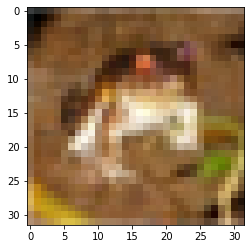

In [388]:
plt.imshow(x_train[0])

In [43]:
print(y_train[0])

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [234]:
def pred_from_server(img):
    result = 0
    pred_url = f'{host}/evasion/api/predict'
    response_predict = requests.post(pred_url, data=img.tobytes(), headers=headers)
    if response_predict.status_code == 200:
        pred = np.array(json.loads(response_predict.text)['data'])
        result = np.argmax(pred, axis=1)[0]
    return result

In [235]:
pred_from_server(x_train[0])

6

In [66]:
def generate_model():
    return tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(32, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Activation('softmax')
    ])

In [67]:
model = generate_model()

2022-02-06 16:59:05.223765: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-06 16:59:05.223930: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-06 16:59:05.224027: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (stud19.datalab.sec.tu-bs.de): /proc/driver/nvidia/version does not exist
2022-02-06 16:59:05.225276: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [68]:
def compile_model(model):
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(
    from_logits=True),
                optimizer='adam',
                metrics=['accuracy'])
    return model

In [69]:
model = compile_model(model)

In [70]:
def train_model(model, x_train, y_train, x_test, y_test, epochs=30):
    model.fit(x_train, y_train, batch_size=256, epochs=epochs, validation_data=(x_test, y_test), shuffle=True)

In [71]:
train_model(model, x_train, y_train, x_test, y_test)

2022-02-06 17:04:17.735816: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
/home/stud19/env/lib/python3.8/site-packages/keras/backend.py:4846: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


Epoch 1/30
196/196 [==============================] - 84s 425ms/step - loss: 1.7352 - accuracy: 0.3617 - val_loss: 1.3960 - val_accuracy: 0.4943
Epoch 2/30
196/196 [==============================] - 81s 416ms/step - loss: 1.3198 - accuracy: 0.5259 - val_loss: 1.1363 - val_accuracy: 0.5995
Epoch 3/30
196/196 [==============================] - 81s 413ms/step - loss: 1.1415 - accuracy: 0.5956 - val_loss: 0.9879 - val_accuracy: 0.6548
Epoch 4/30
196/196 [==============================] - 81s 414ms/step - loss: 1.0177 - accuracy: 0.6399 - val_loss: 0.9045 - val_accuracy: 0.6838
Epoch 5/30
196/196 [==============================] - 81s 413ms/step - loss: 0.9316 - accuracy: 0.6720 - val_loss: 0.8499 - val_accuracy: 0.7076
Epoch 6/30
196/196 [==============================] - 81s 411ms/step - loss: 0.8672 - accuracy: 0.6961 - val_loss: 0.8180 - val_accuracy: 0.7183
Epoch 7/30
196/196 [==============================] - 82s 416ms/step - loss: 0.8051 - accuracy: 0.7159 - val_loss: 0.7483 - val_ac

In [72]:
## Test your current model and predict some images with it
(loss, acc) = model.evaluate(x=x_test, y=y_test, verbose=0)
print("[INFO] loss: {:.4f}, acc: {:.4f}".format(loss, acc))

[INFO] loss: 0.6297, acc: 0.7949


In [726]:
loss_fn = tf.keras.losses.Poisson() #tf.keras.losses.CategoricalCrossentropy()

# Generating the adversarial examples:
I tried generating adversarial examples using the methods: Fast Gradient Sign Method (FGSM), Basic Iterative Method and at last the Iterative Least-Likely Class Method, which performed best in my case. The following method "generate_image_adversary" implements the last method.

In [2335]:
def generate_image_adversary(model, image, label, eps=2 /255.0):
    # cast the image
    image = tf.cast(image, tf.float32)
    # record our gradients
    with tf.GradientTape() as tape:
        # explicitly indicate that our image should be tacked for
        # gradient updates
        tape.watch(image)
        # use our model to make predictions on the input image and
        # then compute the loss
        pred = model(image)
        #loss = loss_fn(label, pred)
        loss = loss_fn(pred, label)
        #loss = tf.keras.losses.MSE(label, pred)
    # calculate the gradients of loss with respect to the image, then
    # compute the sign of the gradient
    gradient = tape.gradient(loss, image)#+0.005
    signedGrad = tf.sign(gradient) 
    # construct the image adversary
    #adversary = (image + (signedGrad * eps)).numpy()
    adversary = (image - 0.5*(signedGrad * eps)).numpy()
    # return the image adversary to the calling function
    adversary = np.clip(adversary, 0, 1).astype("float32")
    return adversary

In [2336]:
index_indices = 13
img_to_test = x_train[indices[index_indices]]
print(f'{img_to_test.shape=}')
label_to_test = y_train[indices[index_indices]]
print(f'{label_to_test.shape=}')

img_to_test.shape=(32, 32, 3)
label_to_test.shape=(10,)


In [2337]:
np.argmax(label_to_test)

3

In [2039]:
np.argmax(model.predict(img_to_test.reshape(1, 32, 32, 3)))

4

In [2068]:
adversary = generate_image_adversary(model,
                         img_to_test.reshape(1, 32, 32, 3), label_to_test.reshape(1,10), eps=0.1) #0.1

In [2041]:
pred_adv = model.predict(adversary)
adversary = adversary.reshape(32,32,3)

In [2046]:
pred_adv.shape

(1, 10)

In [2048]:
np.argmax(pred_adv)

4

In [ ]:
*****************************************

In [2338]:
img_to_test = img_to_test.reshape(1, 32, 32, 3)

In [2339]:
least_likely_class = np.argmin(model.predict(img_to_test), 1)

In [2340]:
one_hot_ll_class = tf.one_hot(least_likely_class, 10)
print(one_hot_ll_class.shape)

(1, 10)


In [2341]:
adversary_least_likely = generate_image_adversary(model,
                         img_to_test.reshape(1, 32, 32, 3), one_hot_ll_class, eps=0.1) #0.1

In [2342]:
adversary_least_likely=adversary_least_likely.reshape(1, 32, 32, 3)

In [2343]:
pred_adv_least_likely = model.predict(adversary_least_likely)
adversary_least_likely = adversary_least_likely.reshape(32,32,3)
print(np.argmax(pred_adv_least_likely))

9


In [2344]:
pred_from_server(adversary_least_likely)

9

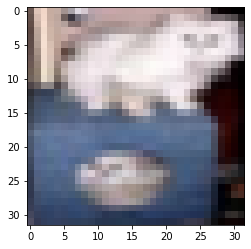

In [2345]:
plt.imshow(img_to_test.reshape(32, 32, 3))

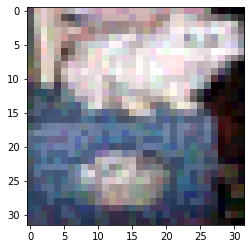

In [2346]:
plt.imshow(adversary_least_likely)

(32, 32, 3)

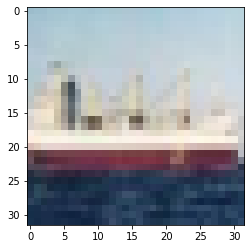

In [480]:
plt.imshow(x_train[indices[0]])
x_train[indices[0]].shape

In [481]:
imgs = [generate_image_adversary(model,
                         x_train[i].reshape(1, 32, 32, 3), y_train[i], eps=0.03) for i in indices]

In [482]:
imgs = np.vstack(imgs)

In [483]:
imgs.shape

(100, 32, 32, 3)

In [484]:
data = imgs.tobytes()

In [485]:
challenge_id

5

In [2362]:
url_solve_challenge = f"{host}/evasion/api/solve_challenge/{challenge_id}"

In [487]:
response_solve_challenge = requests.post(url_solve_challenge,
                                            data = data,
                                            headers = headers)

In [488]:
print(response_solve_challenge.status_code)

500


In [489]:
print(response_solve_challenge.text)


<!doctype html>
<html lang="en">
<head>
  <title>Server Error (500)</title>
</head>
<body>
  <h1>Server Error (500)</h1><p></p>
</body>
</html>



In [ ]:
# adversary_least_likely
#tf.one_hot(np.argmin(model.predict(y_train[i].reshape(1, 32, 32, 3)), 1), 10)

In [2354]:
imgs = [generate_image_adversary(model,
                         x_train[i].reshape(1, 32, 32, 3), tf.one_hot(np.argmin(model.predict(x_train[i].reshape(1, 32, 32, 3)), 1), 10), eps=0.1) for i in indices]

In [2355]:
imgs = np.vstack(imgs)

In [2356]:
imgs.shape

(100, 32, 32, 3)

In [2357]:
data = imgs.tobytes()

In [2358]:
challenge_id

7

In [2363]:
response_solve_challenge = requests.post(url_solve_challenge,
                                            data = data,
                                            headers = headers)

In [2364]:
print(response_solve_challenge.status_code)

200


In [2365]:
print(response_solve_challenge.text)

eyJub25jZSI6ICI3cUJGV3ZtNGJLLzVoQTNNKzdocm1RPT0iLCAidG9rZW4iOiAiQ2xIZXFMaGpjS0U5TEV3b0d4TUZoNFNjUS9RTm51aHMzSnM5bXhaM01PdGZEM2RndlNHRkVuTTVDRFlDZ1FLYk1VamFRTHUya2s5R1VNWW5wOVhBOVR0dkZhMVRPRnZLVkdseS9wc3Uxbmtza1BCUDBTTVZVTXIxTzdHSVROSk5JS20wUVRoK2p0S1doeitVc0RjK1Z2YitUWVVzZzVhQnJFbExpZ0JZRDA5WThZdTJZeDUyZmR4T3V1Z29ZdzBSRDY3V0tnPT0iLCAidGFnIjogImY2S3crQTMxNEI3MWJUNWxOQ2s5c2c9PSJ9
